# Dueling Double Deep Q-Network (DDDQN)
---
Implementation of the agent with OpenAI Gym's LunarLander-v2 environment. The code is based on materials from Udacity Deep Reinforcement Learning Nanodegree Program. 

### 1. Import the Necessary Packages

The Model

In [1]:
!pip install gym  torch
!apt-get install python-opengl ffmpeg -y 
!apt install xvfb -y 
!pip install pyvirtualdisplay  
!pip install piglet 
!pip install gym[box2d] 
!pip install tensorflow 

Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:3.4.8-0ubuntu0.2).
Suggested packages:
  libgle3
The following NEW packages will be installed:
  python-opengl
0 upgraded, 1 newly installed, 0 to remove and 29 not upgraded.
Need to get 496 kB of archives.
After this operation, 5,416 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 python-opengl all 3.1.0+dfsg-1 [496 kB]
Fetched 496 kB in 1s (676 kB/s)
Selecting previously unselected package python-opengl.
(Reading database ... 160975 files and directories currently installed.)
Preparing to unpack .../python-opengl_3.1.0+dfsg-1_all.deb ...
Unpacking python-opengl (3.1.0+dfsg-1) ...
Setting up python-opengl (3.1.0+dfsg-1) ...
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  xvfb
0 upgraded, 1 newly install

In [2]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

In [3]:
# This code creates a virtual display to draw game images on. 
# If you are running locally, just ignore it
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

In [4]:
import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) # error only
# import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML

from IPython import display as ipythondisplay
from collections import namedtuple
from itertools import count

In [5]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
  """
  Utility functions to enable video recording of gym environment and displaying it
  To enable video, just do "env = wrap_env(env)
  """
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

In [6]:
class defaultActions:
    def __init__(self):

        self.main = [[1    , "Main strong"],
                     [0.51 ,"Main slow"],
#                      [0.75 , "Main meduim"],
                     [0 , "Main off"]
                    ]
        self.left_right = [
                        [0, "Left Right off"],
                        [-0.5 , "Left slow"],
#                         [-0.75  , "Left meduim"],
                        [-1 , "Left strong"],
                        
                        [0.5 , "Right slow"],
#                         [0.75  , "Right meduim"],
                        [1 , "Right strong"],
                        ]
        self.all_actions = {}
        i = 0  
        for main_eng in self.main:
            for sec_eng in self.left_right:
#                 print (f"a{i},act:[{main_eng[0]},{sec_eng[0]},{main_eng[1]} {sec_eng[1]}]")
                self.all_actions[i] = [[main_eng[0],sec_eng[0]] , f"{main_eng[1]}, {sec_eng[1]}"]
                i+=1
        
    def get_full_action(self,id):
        """
        :param id: id of action 
        :return: return action and discription
        """
        return self.all_actions[id]

    def get_action(self,id,add_noise=False):
        """
        :param id: id of action 
        :param add_noise: add noise to the engains
        :return: engain vector
        """
        if add_noise :
            return [self.all_actions[id][0][0]+make_noise(), self.all_actions[id][0][1]+make_noise()]
        else:
            return self.all_actions[id][0]

    def get_description(self,id):
         """
        :param id: id of action 
        :return: return discription
        """     
        return self.all_actions[id][1]
    def get_action_count(self):
        """ 
        :return: return actions count
        """
        return len(self.all_actions)
actions = defaultActions()

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class QNetwork(nn.Module):

    def __init__(self, state_size, action_size, seed, fc1_size = 64, fc2_size = 64):
        """
        Initialize parameters and build model.

        :param state_size: len of states
        :param action_size: len of actions
        :param seed: Random seed  
        """        
        
        super(QNetwork, self).__init__()
        hidden_size = 30
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_size)
        self.fc2 = nn.Linear(fc1_size, fc2_size)
        self.out = nn.Linear(fc2_size, action_size)
        

    def forward(self, state):
        x = self.fc1(state)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        action = self.out(x)
        return action
    
class DuelingQNetwork(nn.Module):

    def __init__(self, state_size, action_size, seed, fc1_size = 64, fc2_size = 64):

        """
        Initialize parameters and build model.

        :param state_size: len of states
        :param action_size: len of actions
        :param seed: Random seed  
        """   
        
        super(DuelingQNetwork, self).__init__()
        self.num_actions = action_size
        fc3_1_size = fc3_2_size = 32
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_size)
        self.fc2 = nn.Linear(fc1_size, fc2_size)
        ## Here we separate into two streams
        # The one that calculate V(s)
        self.fc3_1 = nn.Linear(fc2_size, fc3_1_size)
        self.fc4_1 = nn.Linear(fc3_1_size, 1)
        # The one that calculate A(s,a)
        self.fc3_2 = nn.Linear(fc2_size, fc3_2_size)
        self.fc4_2 = nn.Linear(fc3_2_size, action_size)



    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))

        val = F.relu(self.fc3_1(x))
        val = self.fc4_1(val)
        
        adv = F.relu(self.fc3_2(x))
        adv = self.fc4_2(adv)
        # Q(s,a) = V(s) + (A(s,a) - 1/|A| * sum A(s,a'))
        action = val + adv - adv.mean(1).unsqueeze(1).expand(state.size(0), self.num_actions)
        return action

The agent

In [8]:
import numpy as np
import random
from collections import namedtuple, deque


import torch
import torch.nn.functional as F
import torch.optim as optim

BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 16        # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 0.000368               # learning rate 
UPDATE_EVERY = 4        # how often to update the network

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Agent():

    def __init__(self, state_size, action_size, seed):
        """
        Initialize an Agent object.
        
        :param state_size: len of states
        :param action_size: len of actions
        :param seed: Random seed  
        """   
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        # Q-Network
        self.qnetwork_local = DuelingQNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = DuelingQNetwork(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0
    
    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
        
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn_DDQN(experiences, GAMMA)

    def act(self, state, eps=0.):
        """
        :param state: current state
        :param eps : epsilon, for epsilon-greedy action selection
        :param seed: Random seed 
        :return: actions for given state as per current policy.  
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        """
        Update value parameters using given batch of experience tuples.

        :param state: experiences : tuple of (s, a, r, s', done) tuples 
        :param gamma: discount factor
        """
        states, actions, rewards, next_states, dones = experiences
        # Get max predicted Q values (for next states) from target model
        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        # Compute Q targets for current states 
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        # Get expected Q values from local model
        Q_expected = self.qnetwork_local(states).gather(1, actions)

        # Compute loss
        loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)  
        
       
    def learn_DDQN(self, experiences, gamma):
        """
        Update value parameters using given batch of experience tuples.

        :param state: experiences : tuple of (s, a, r, s', done) tuples 
        :param gamma: discount factor
        """
        states, actions, rewards, next_states, dones = experiences
        # Get index of maximum value for next state from Q_expected
        Q_argmax = self.qnetwork_local(next_states).detach()
        _, a_prime = Q_argmax.max(1)
        #print (self.qnetwork_local(states).detach())
        # Get max predicted Q values (for next states) from target model
        Q_targets_next = self.qnetwork_target(next_states).detach().gather(1, a_prime.unsqueeze(1))
        #print (Q_targets_next.shape)
        # Compute Q targets for current states 
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        #print (Q_targets.shape)
        # Get expected Q values from local model
        Q_expected = self.qnetwork_local(states).gather(1, actions)
        #print (Q_expected.shape)
        # Compute loss
        loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)  

    def soft_update(self, local_model, target_model, tau):
        """
        Soft update model parameters.

        :param local_model: weights will be copied from
        :param target_model : weights will be copied to
        :param tau : interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)


class ReplayBuffer:

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """
        Initialize a ReplayBuffer object.

        :param action_size: dimension of each action
        :param buffer_size: maximum size of buffer
        :param batch_size: size of each training batch
        :param seed: random seed 
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        return len(self.memory)

In [9]:
import gym
!pip install box2d
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

!python -m pip install pyvirtualdisplay
#from pyvirtualdisplay import Display
#display = Display(visible=0, size=(1400, 900))
#display.start()

is_ipython = 'inline' in plt.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

     |████████████████████████████████| 1.3MB 5.6MB/s 


### 2. Instantiate the Environment and Agent

Initialize the environment in the code cell below.

In [10]:
# env = gym.make('LunarLander-v2')
# env.seed(0)
env = gym.make('LunarLanderContinuous-v2')
env.seed(0)
env.reset()
env = wrap_env(env)
np.random.seed(0)
print('State shape: ', env.observation_space.shape)
# print('Number of actions: ', env.action_space.n)

State shape:  (8,)


### 3. Train the Agent 

Run the code cell below to train the agent from scratch. 

Episode 100	Average Score: -362.85
Episode 200	Average Score: -273.62
Episode 300	Average Score: -116.58
Episode 400	Average Score: -127.69
Episode 500	Average Score: -80.79
Episode 600	Average Score: -64.65
Episode 700	Average Score: -51.72
Episode 800	Average Score: -32.06
Episode 900	Average Score: -16.36
Episode 1000	Average Score: 9.84
Episode 1100	Average Score: 70.15
Episode 1200	Average Score: 87.04
Episode 1300	Average Score: 138.47
Episode 1400	Average Score: 181.56
Episode 1445	Average Score: 200.98
Environment solved in 1345 episodes!	Average Score: 200.98


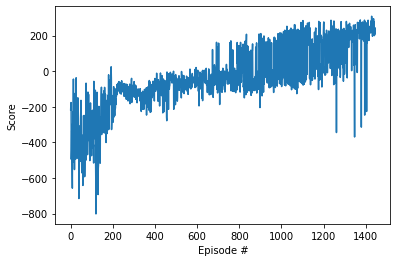

In [11]:



def train(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """
        Deep Q-Learning.

        :param n_episodes: maximum number of training episodes
        :param max_t: maximum number of timesteps per episode
        :param eps_start: starting value of epsilon, for epsilon-greedy action selection
        eps_end: minimum value of epsilon
        eps_decay: multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            action_step = actions.get_action(action)
            next_state, reward, done, _ = env.step(action_step)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=200.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint_Dueling_DDQN.pth')
            break
    return scores
agent = Agent(state_size=8, action_size=actions.get_action_count(), seed=0)
scores = train()

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [ ]:
for lr in np.arange(0.0005,0.05,0.0005):
    agent = Agent(state_size=8, action_size=actions.get_action_count(), seed=0)
    scores = train()

    # plot the scores
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(len(scores)), scores)
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.show()

### 4. Watch a Smart Agent!

In the next code cell, you will load the trained weights from file to watch a smart agent!

avg: 212.92129346717272


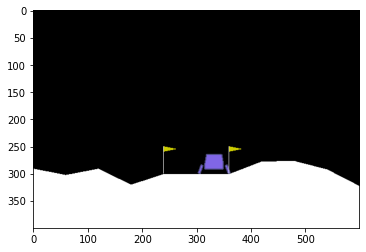

In [12]:

agent = Agent(state_size=8, action_size=actions.get_action_count(), seed=0)
agent.qnetwork_local.load_state_dict(torch.load('checkpoint_Dueling_DDQN.pth', map_location=lambda storage, loc: storage))
sum = 0
for i in range(200):
    print(f"episode {i}")
    state = env.reset()
    Total_reward = 0
    # if i >= 199:
    #     img = plt.imshow(env.render(mode='rgb_array'))
    for j in range(3000):
        action = agent.act(state)
        # if i >= 199:
        #     img.set_data(env.render(mode='rgb_array')) 
        #     # plt.axis('off')
        #     display.display(plt.gcf())
        #     display.clear_output(wait=True)
        action_step = actions.get_action(action)        
        state, reward, done, _ = env.step(action_step)
        Total_reward += reward
        if done:
            break 
    sum += Total_reward
avg = sum / 200
print(f"avg: {avg}")
              
env.close()
show_video()  